## _PandaML_
- Perform detailed _Exploratory Data Analysis_ (EDA) on STT Data.

In [1]:
import sys, os, glob, yaml

In [2]:
import math
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import trackml.dataset
import seaborn as sns

In [4]:
sys.path.append('src')

### _Dataset_

In [5]:
# mu- data (current)
#input_dir = './data_sets/pandaml/data_3.0_7.0_GeV/'

# mu+mu- data (coming)
input_dir = './data_0.1_1.5_GeV/'

# pbarp data (coming)
# input_dir = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [6]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [7]:
# file_prefixes[:10]

In [8]:
event_id = 1
event_prefix = file_prefixes[event_id]

In [9]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000001 memory usage 0.07 MB


In [10]:
# preprocess hits
# hits['r'] = hits.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
hits = hits.assign(r=hits.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1))
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,r
0,1,15.744300,-10.100,35.0,9,0,68,18.705427
1,2,16.618999,-10.605,35.0,9,1,176,19.714390
2,3,17.493700,-11.110,35.0,9,2,290,20.723456
3,4,18.368401,-11.615,35.0,9,3,410,21.732611
4,5,18.368401,-12.625,35.0,9,4,535,22.288759


In [11]:
tubes.head()

,hit_id,isochrone,depcharge,energyloss,volume_id,layer_id,module_id,skewed,sector_id
0,1,0.018887,13688700.0,13.6887,9,0,68,0,3
1,2,0.102864,17768800.0,17.7688,9,1,176,0,3
2,3,0.278482,9376200.0,9.3762,9,2,290,0,3
3,4,0.405173,11936600.0,11.9366,9,3,410,0,3
4,5,0.373419,10978700.0,10.9787,9,4,535,0,3


In [12]:
# preprocess particles (I've duplicates: so drop duplicates, sort and reset_index) 
particles.drop_duplicates(inplace=True)
particles = particles.sort_values(by=['particle_id']).reset_index(drop=True)
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,0.450697,0.826248,1.651660,1,1,13,0
1,2,0.0,0.0,0.0,2.105750,0.175914,-1.982920,1,1,13,0
2,3,0.0,0.0,0.0,1.844310,-0.404569,-0.978350,1,1,13,0
3,4,0.0,0.0,0.0,-0.489864,0.429600,1.471420,1,1,13,0
4,5,0.0,0.0,0.0,1.165630,0.821105,-0.322351,1,1,13,0


In [13]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,15.766300,-10.0713,29.702999,0.233502,-0.178933,0.465225,1.0,15
1,2,16.556900,-10.6842,31.285200,0.231199,-0.181274,0.465430,1.0,15
2,3,17.338600,-11.3036,32.864899,0.229244,-0.183621,0.465429,1.0,15
3,4,18.111300,-11.9288,34.441299,0.226648,-0.185823,0.465772,1.0,15
4,5,18.606899,-12.3383,35.463200,0.225201,-0.187322,0.465825,1.0,15


### _Detector Layout_

In [14]:
from src.drawing import draw_single_event

In [15]:
def display_event(path="", event_id=1):
    prefix = path + str('event{!s}'.format(format(event_id, '010d')))
    hits = trackml.dataset.load_event_hits(prefix)
    draw_single_event(hits, event_id, "event", (10, 10), False)

(-41.0, 41.0)

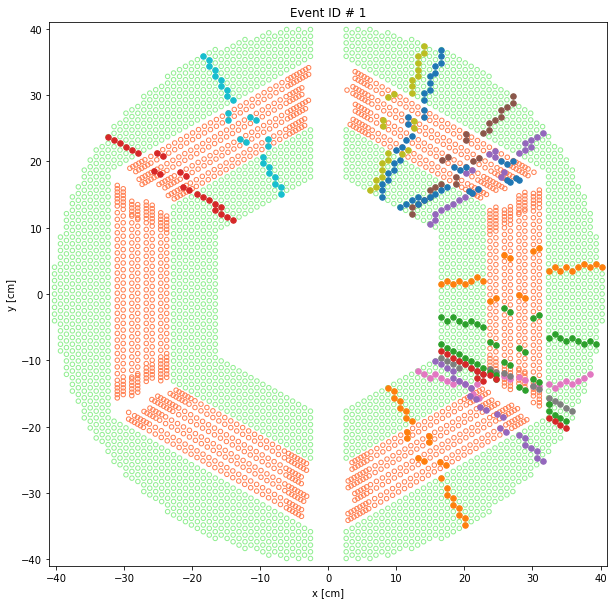

In [16]:
p_ids = np.unique(particles.particle_id.values)
det = pd.read_csv("src/stt.csv")
# plt.style.use('seaborn')
# fig = plt.gcf()
fig = plt.figure(figsize=(10,10))
skw = det.query('skewed==0')
nkw = det.query('skewed==1')
plt.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
plt.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')
for i in p_ids:
    df_ = hits.loc[truth.particle_id == i]
    plt.scatter(df_.x.values, df_.y.values, s=30, label='particle_id: %d' % i)
plt.title('Event ID # %d' % event_id)
plt.xlabel('x [cm]', fontsize=10)
plt.ylabel('y [cm]', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim((-41, 41))
plt.ylim((-41, 41))

### _Draw Tracks_

In [17]:
# we already have r - sorted hits, lets draw a single track.
data = hits[truth['particle_id'] == 5]

Text(0, 0.5, 'y [cm]')

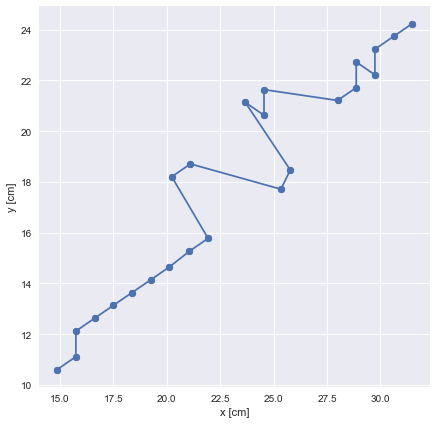

In [18]:
# Using Object Oriented API
plt.close('all')
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
plt.scatter(data.x, data.y)
plt.plot(data.x, data.y, "-o")
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
# ax.set_xlim(5, 40)
# ax.set_ylim(5, 40)
# plt.savefig(os.path.join(outdir, "event.png"))

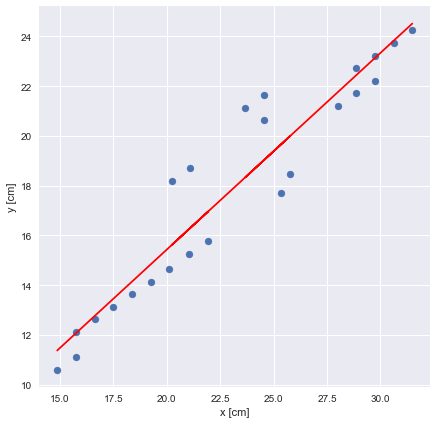

In [19]:
# numpy.polyfit() function
plt.close('all')
plt.style.use('seaborn')
fig = plt.figure(figsize=(7,7))

a, b = np.polyfit(data.x, data.y, 1)

plt.scatter(data.x, data.y)
plt.plot(data.x, a*data.x+b, 'r')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
#plt.xlim((5, 40))
#plt.ylim((5, 40))
plt.show()

### _Momentum Distributions_

In [20]:
# calculate pt
particles = particles.assign(pt=particles.apply(lambda row: np.sqrt(row.px**2 + row.py**2), axis=1))

In [21]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,pt
0,1,0.0,0.0,0.0,0.450697,0.826248,1.651660,1,1,13,0,0.941177
1,2,0.0,0.0,0.0,2.105750,0.175914,-1.982920,1,1,13,0,2.113085
2,3,0.0,0.0,0.0,1.844310,-0.404569,-0.978350,1,1,13,0,1.888162
3,4,0.0,0.0,0.0,-0.489864,0.429600,1.471420,1,1,13,0,0.651554
4,5,0.0,0.0,0.0,1.165630,0.821105,-0.322351,1,1,13,0,1.425800


In [27]:
particles.pt

0     0.941177
1     2.113085
2     1.888162
3     0.651554
4     1.425800
5     0.940721
6     0.100003
7     0.513932
8     0.958428
9     0.690566
10    0.099174
11    1.145181
12    0.517604
13    0.892112
14    0.298886
Name: pt, dtype: float64

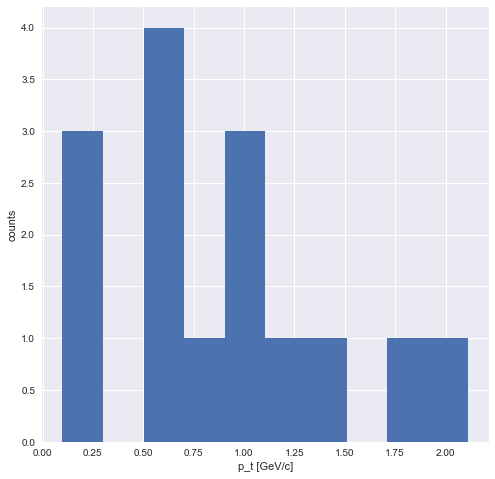

In [29]:
plt.close('all')
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,8))

plt.hist(particles.pt)

plt.xlabel('p_t [GeV/c]')
plt.ylabel('counts')
#plt.xlim((3, 7))
#plt.ylim((5, 40))
plt.show()

In [30]:
# _ = particles[['px','py','pt']].hist(figsize = (8,8))

In [31]:
# Number of unique particles
len(truth.particle_id.unique())

15

In [32]:
# lets get unique pids with freq (~ hits).
sel_pids, sel_pids_fr = np.unique(particles.particle_id, return_counts=True)
sel_pids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [25]:
print("Average number of hits per tracks: {}".format(hits.hit_id.count()/sel_pids.size))

Average number of hits per tracks: 23.866666666666667
